## Import Packages

In [67]:
# Importing necessary libraries
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
import optuna

## Drop Highly Correlated Features

In [68]:
# Function to drop highly correlated features
def drop_highly_correlated_features(df, threshold=0.95):
    corr_matrix = df.corr().abs()
    upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > threshold)]
    return df.drop(columns=to_drop), to_drop

## Load Training Dataset

In [69]:
# Path to the directory containing your CSV files
data_dir = 'E:\\Features_Dataset'

In [70]:
# Load all CSV files into a list of dataframes
dataframes = []
for filename in os.listdir(data_dir):
    if filename.endswith('.csv'):
        df = pd.read_csv(os.path.join(data_dir, filename))
        dataframes.append(df)

## Prepare Data For Training

In [71]:
# Drop the "cycle index" column
dataframes = [df.drop(columns=['Cycle_Index'], errors='ignore') for df in dataframes]

In [72]:
# Combine all datasets into a single DataFrame
all_data = pd.concat(dataframes, axis=0, ignore_index=True)

In [73]:
# Drop highly correlated features
all_data, dropped_columns = drop_highly_correlated_features(all_data)
print(f"Dropped columns due to high correlation: {dropped_columns}")

Dropped columns due to high correlation: ['A_CV', 'T_CV', 'T_CC', 'Cum_Discharge_Energy', 'Frechet_Distance_CC', 'Hausdorff_Distance_CV', 'Energy_CC', 'Energy_Ratio', 'Energy_Diff']


In [74]:
# Separate features and target variable
X = all_data.drop(columns=['Nominal_Capacity'])
y = all_data['Nominal_Capacity']

In [75]:
# Scale features and target variable
scaler_X = StandardScaler()
scaler_y = StandardScaler()

In [76]:
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

In [77]:
# Reshape data for LSTM: (samples, time steps, features)
time_steps = 10
X_lstm = []
y_lstm = []

for i in range(len(X_scaled) - time_steps):
    X_lstm.append(X_scaled[i:i + time_steps])
    y_lstm.append(y_scaled[i + time_steps])

X_lstm, y_lstm = np.array(X_lstm), np.array(y_lstm)

## Split into Training and Validation Sets

In [78]:
# Split into training and validation sets
# Select first 80 dataframes for training and remaining for validation
train_dataframes = dataframes[:80]
val_dataframes = dataframes[80:]

# Prepare training data
X_train_list = []
y_train_list = []
for df in train_dataframes:
    df = df.drop(columns=['Cycle_Index'], errors='ignore')
    df = df.drop(columns=dropped_columns, errors='ignore')
    X_train_list.append(scaler_X.transform(df.drop(columns=['Nominal_Capacity'])))
    y_train_list.append(scaler_y.transform(df['Nominal_Capacity'].values.reshape(-1, 1)))

X_train = np.concatenate(X_train_list)
y_train = np.concatenate(y_train_list)

# Prepare validation data
X_val_list = []
y_val_list = []
for df in val_dataframes:
    df = df.drop(columns=['cycle index'], errors='ignore')
    df = df.drop(columns=dropped_columns, errors='ignore')
    X_val_list.append(scaler_X.transform(df.drop(columns=['Nominal_Capacity'])))
    y_val_list.append(scaler_y.transform(df['Nominal_Capacity'].values.reshape(-1, 1)))

X_val = np.concatenate(X_val_list)
y_val = np.concatenate(y_val_list)

In [79]:
# Reshape for LSTM
X_train_lstm, y_train_lstm = [], []
X_val_lstm, y_val_lstm = [], []

for i in range(len(X_train) - time_steps):
    X_train_lstm.append(X_train[i:i + time_steps])
    y_train_lstm.append(y_train[i + time_steps])

for i in range(len(X_val) - time_steps):
    X_val_lstm.append(X_val[i:i + time_steps])
    y_val_lstm.append(y_val[i + time_steps])

X_train_lstm, y_train_lstm = np.array(X_train_lstm), np.array(y_train_lstm)
X_val_lstm, y_val_lstm = np.array(X_val_lstm), np.array(y_val_lstm)

In [80]:
# Define the objective function for Optuna
def objective(trial):
    units = trial.suggest_int('units', 10, 100)
    batch_size = trial.suggest_int('batch_size', 16, 128)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
    
    # Define the LSTM model
    model = Sequential()
    model.add(LSTM(units=units, return_sequences=True, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
    model.add(LSTM(units=units))
    model.add(Dense(1))
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    # Train the model
    model.fit(X_train_lstm, y_train_lstm, epochs=10, batch_size=batch_size, validation_data=(X_val_lstm, y_val_lstm), verbose=0)
    
    # Evaluate the model
    val_loss = model.evaluate(X_val_lstm, y_val_lstm, verbose=0)
    
    return val_loss

# Create a study and optimize the objective function
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

# Retrieve the best parameters
best_params = study.best_params
best_units = best_params['units']
best_batch_size = best_params['batch_size']
best_learning_rate = best_params['learning_rate']

print(f"Optimal parameters: Units: {best_units}, Batch Size: {best_batch_size}, Learning Rate: {best_learning_rate}")

[I 2024-05-22 05:04:28,211] A new study created in memory with name: no-name-d23b00ca-37a0-4373-a7cb-ff02b423a4b1
C:\Users\Rishi\AppData\Local\Temp\ipykernel_16000\302332368.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
[I 2024-05-22 05:10:11,892] Trial 0 finished with value: 0.011735846288502216 and parameters: {'units': 92, 'batch_size': 75, 'learning_rate': 0.001516663133298242}. Best is trial 0 with value: 0.011735846288502216.
[I 2024-05-22 05:14:17,889] Trial 1 finished with value: 0.013776837848126888 and parameters: {'units': 71, 'batch_size': 99, 'learning_rate': 0.001934544053896591}. Best is trial 0 with value: 0.011735846288502216.
[I 2024-05-22 05:18:46,780] Trial 2 finished with value: 0.010825865902006626 and parameters: {'units': 99, 'ba

Optimal parameters: Units: 99, Batch Size: 128, Learning Rate: 0.0009992121970574062


In [81]:
# Train the final model with optimal parameters
model = Sequential()
model.add(LSTM(units=best_units, return_sequences=True, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
model.add(LSTM(units=best_units))
model.add(Dense(1))

optimizer = tf.keras.optimizers.Adam(learning_rate=best_learning_rate)
model.compile(optimizer=optimizer, loss='mean_squared_error')

## Train the Model

In [82]:
history = model.fit(X_train_lstm, y_train_lstm, epochs=50, batch_size=best_batch_size, validation_data=(X_val_lstm, y_val_lstm), verbose=2)

Epoch 1/50
443/443 - 37s - loss: 0.0457 - val_loss: 0.0125 - 37s/epoch - 84ms/step
Epoch 2/50
443/443 - 25s - loss: 0.0198 - val_loss: 0.0107 - 25s/epoch - 57ms/step
Epoch 3/50
443/443 - 25s - loss: 0.0177 - val_loss: 0.0105 - 25s/epoch - 55ms/step
Epoch 4/50
443/443 - 26s - loss: 0.0171 - val_loss: 0.0102 - 26s/epoch - 58ms/step
Epoch 5/50
443/443 - 23s - loss: 0.0159 - val_loss: 0.0101 - 23s/epoch - 51ms/step
Epoch 6/50
443/443 - 22s - loss: 0.0148 - val_loss: 0.0108 - 22s/epoch - 49ms/step
Epoch 7/50
443/443 - 23s - loss: 0.0154 - val_loss: 0.0120 - 23s/epoch - 52ms/step
Epoch 8/50
443/443 - 22s - loss: 0.0135 - val_loss: 0.0108 - 22s/epoch - 50ms/step
Epoch 9/50
443/443 - 22s - loss: 0.0135 - val_loss: 0.0107 - 22s/epoch - 50ms/step
Epoch 10/50
443/443 - 23s - loss: 0.0123 - val_loss: 0.0115 - 23s/epoch - 53ms/step
Epoch 11/50
443/443 - 23s - loss: 0.0119 - val_loss: 0.0131 - 23s/epoch - 52ms/step
Epoch 12/50
443/443 - 22s - loss: 0.0102 - val_loss: 0.0125 - 22s/epoch - 50ms/step
E

In [ ]:
# Plot training and validation loss over epochs
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Epoch vs Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Save the plot if save_path is provided
save_path = 'C:\\Users\\Rishi\\Documents\\Images\\PSO_Pred_Epoch vs Loss'

if save_path:
    plt.savefig(save_path)
    print(f"Plot saved to {save_path}")

plt.show()

## Load Testing Data

In [83]:
# Path to the directory containing all testing datasets
test_data_dir = 'E:\\Testing Data'

In [84]:
# Initialize lists to store predictions and actual values for each dataset
all_predictions = []
all_actual_values = []

## Predict the Capacity

In [85]:
# Iterate through each file in the folder
for filename in os.listdir(test_data_dir):
    if filename.endswith('.csv'):
        # Read the testing dataset
        test_data_path = os.path.join(test_data_dir, filename)
        test_df = pd.read_csv(test_data_path)

        # Ensure the dataset remains unchanged
        new_data = test_df.copy()

        # Drop the "cycle index" column without modifying the original dataset
        new_data = new_data.drop(columns=['Cycle_Index'], errors='ignore')

        # Drop highly correlated features from the test dataset
        new_data = new_data.drop(columns=dropped_columns, errors='ignore')

        # Separate features and target variable for the dataset
        X_new = new_data.drop(columns=['Nominal_Capacity'])
        y_new = new_data['Nominal_Capacity']

        # Scale the dataset
        X_new_scaled = scaler_X.transform(X_new)
        y_new_scaled = scaler_y.transform(y_new.values.reshape(-1, 1))

        # Reshape for LSTM input
        X_new_lstm = []
        for i in range(len(X_new_scaled) - time_steps):
            X_new_lstm.append(X_new_scaled[i:i + time_steps])

        X_new_lstm = np.array(X_new_lstm)

        # Predict
        predictions_scaled = model.predict(X_new_lstm)

        # Inverse transform the scaled predictions to get back original values
        predictions = scaler_y.inverse_transform(predictions_scaled)
        y_new_descaled = scaler_y.inverse_transform(y_new_scaled[time_steps:])

        # Append predictions and actual values to the lists
        all_predictions.append(predictions)
        all_actual_values.append(y_new_descaled)

22/22 [==============================] - 0s 12ms/step


## Evaluation of Metrics

In [86]:
# Calculate overall metrics
all_predictions = np.concatenate(all_predictions)
all_actual_values = np.concatenate(all_actual_values)

mae = mean_absolute_error(all_actual_values, all_predictions)
rmse = np.sqrt(mean_squared_error(all_actual_values, all_predictions))
mape = np.mean(np.abs((all_actual_values - all_predictions) / all_actual_values)) * 100
r2 = r2_score(all_actual_values, all_predictions)

print(f'Overall MAE: {mae:.4f}')
print(f'Overall RMSE: {rmse:.4f}')
print(f'Overall MAPE: {mape:.4f}%')
print(f'Overall R-squared: {r2:.4f}')

Overall MAE: 0.0014
Overall RMSE: 0.0047
Overall MAPE: 0.1392%
Overall R-squared: 0.9875


Plot saved to C:\Users\Rishi\Documents\Images\PSO_Pred_All_Data


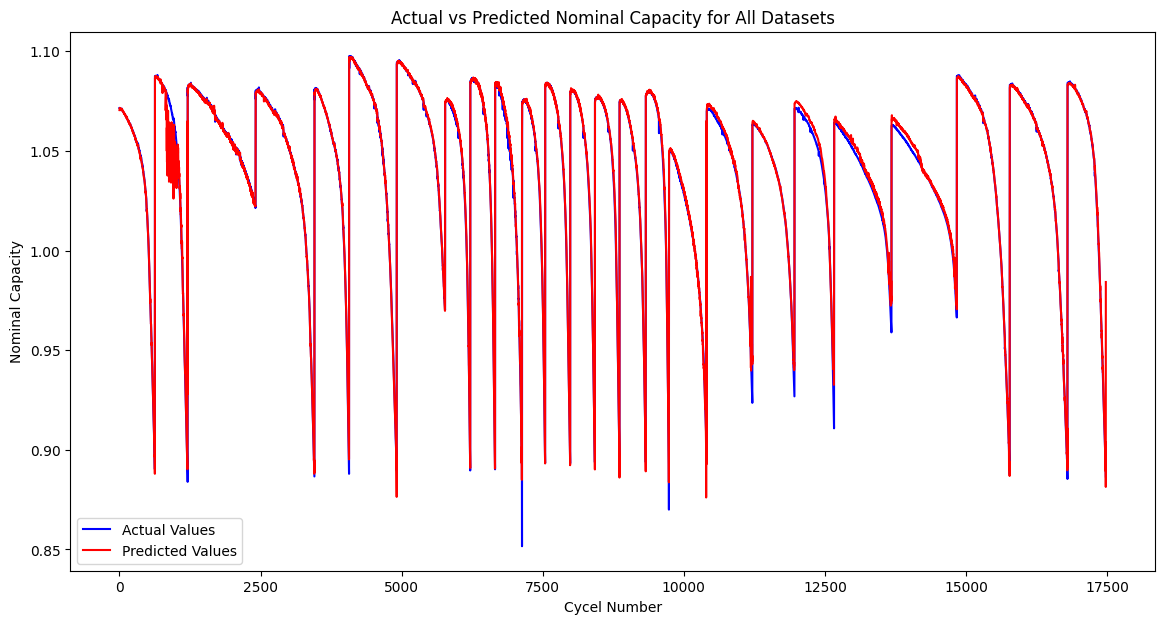

In [87]:
# Plot the actual vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(all_actual_values, label='Actual Values', color='b')
plt.plot(all_predictions, label='Predicted Values', color='r')
plt.title('Actual vs Predicted Nominal Capacity for All Datasets')
plt.xlabel('Cycel Number')
plt.ylabel('Nominal Capacity')
plt.legend()

# Save the plot if save_path is provided
save_path = 'C:\\Users\\Rishi\\Documents\\Images\\PSO_Pred_All_Data'

if save_path:
    plt.savefig(save_path)
    print(f"Plot saved to {save_path}")

plt.show()

## Prediction of Single Dataset

In [88]:
# Function to test on a single dataset and plot the results
def test_single_dataset(test_data_path, model, scaler_X, scaler_y, dropped_columns, time_steps):
    # Read the testing dataset
    test_df = pd.read_csv(test_data_path)

    # Ensure the dataset remains unchanged
    new_data = test_df.copy()

    # Drop the "cycle index" column without modifying the original dataset
    new_data = new_data.drop(columns=['Cycle_Index'], errors='ignore')

    # Drop highly correlated features from the test dataset
    new_data = new_data.drop(columns=dropped_columns, errors='ignore')

    # Separate features and target variable for the dataset
    X_new = new_data.drop(columns=['Nominal_Capacity'])
    y_new = new_data['Nominal_Capacity']

    # Scale the dataset
    X_new_scaled = scaler_X.transform(X_new)
    y_new_scaled = scaler_y.transform(y_new.values.reshape(-1, 1))

    # Reshape for LSTM input
    X_new_lstm = []
    for i in range(len(X_new_scaled) - time_steps):
        X_new_lstm.append(X_new_scaled[i:i + time_steps])

    X_new_lstm = np.array(X_new_lstm)

    # Predict
    predictions_scaled = model.predict(X_new_lstm)

    # Inverse transform the scaled predictions to get back original values
    predictions = scaler_y.inverse_transform(predictions_scaled)
    y_new_descaled = scaler_y.inverse_transform(y_new_scaled[time_steps:])

    # Plot the actual vs predicted values
    plt.figure(figsize=(14, 7))
    plt.plot(y_new_descaled, label='Actual Values', color='b')
    plt.plot(predictions, label='Predicted Values', color='r')
    plt.title('Actual vs Predicted Nominal Capacity for Single Dataset')
    plt.xlabel('Cycle Number')
    plt.ylabel('Nominal Capacity')
    plt.legend()

    # Save the plot if save_path is provided
    save_path = 'C:\\Users\\Rishi\\Documents\\Images\\PSO_Pred_Single_Data'
    
    if save_path:
        plt.savefig(save_path)
        print(f"Plot saved to {save_path}")

    plt.show()

    # Print evaluation metrics
    mae = mean_absolute_error(y_new_descaled, predictions)
    rmse = np.sqrt(mean_squared_error(y_new_descaled, predictions))
    mape = np.mean(np.abs((y_new_descaled - predictions) / y_new_descaled)) * 100
    r2 = r2_score(y_new_descaled, predictions)

    print(f'MAE: {mae:.4f}')
    print(f'RMSE: {rmse:.4f}')
    print(f'MAPE: {mape:.4f}%')
    print(f'R-squared: {r2:.4f}')

In [89]:
# Path to the single testing dataset
single_test_data_path = 'E:\\Testing Data\\Battery_115_Features.csv'

In [90]:
# Path to save the plot
save_plot_path = 'PSO_Pred_Single_Data.png'

13/13 [==============================] - 0s 14ms/step
Plot saved to C:\Users\Rishi\Documents\Images\PSO_Pred_Single_Data


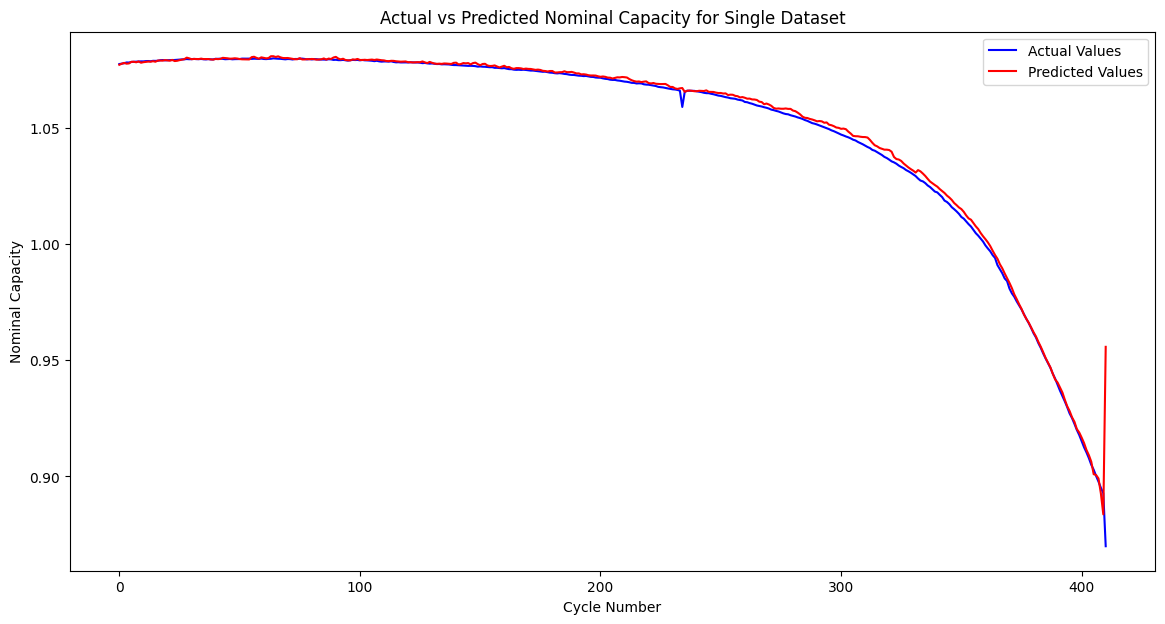

MAE: 0.0013
RMSE: 0.0045
MAPE: 0.1300%
R-squared: 0.9895


In [91]:
# Test the model on the single dataset and plot the graph
test_single_dataset(single_test_data_path, model, scaler_X, scaler_y, dropped_columns, time_steps)